In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  sentiment
0  RT @JohnLeguizamo: #trump not draining swamp b...          0
1  ICYMI: Hackers Rig FM Radio Stations To Play A...          0
2  Trump protests: LGBTQ rally in New York https:...          1
3  "Hi I'm Piers Morgan. David Beckham is awful b...          0
4  RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...          0

Dataset shape: (1850123, 2)

Sentiment distribution:
sentiment
0    1244211
1     605912
Name: count, dtype: int64


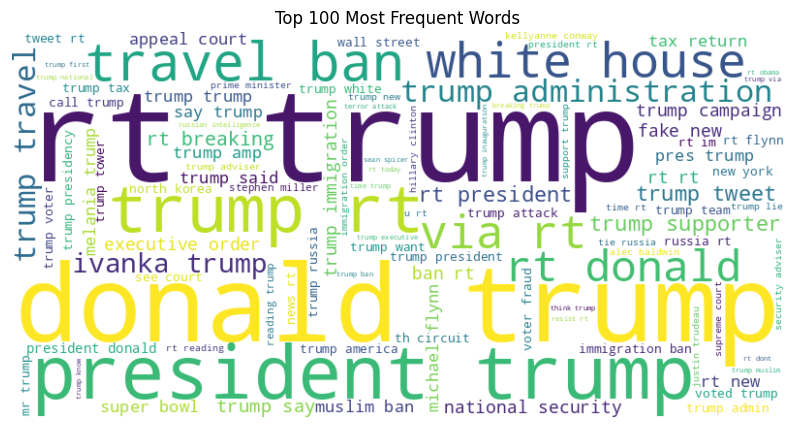

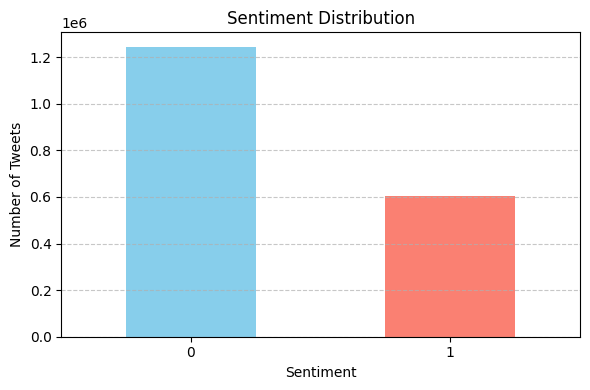

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Workshop8/trum_tweet_sentiment_analysis.csv')

# Check column names and convert to lowercase for consistency
df.columns = df.columns.str.lower()

# View initial rows and dataset info
print(df.head())
print(f"\nDataset shape: {df.shape}")

# Check if 'sentiment' column exists
if 'sentiment' in df.columns:
    print("\nSentiment distribution:")
    print(df['sentiment'].value_counts())
else:
    print("\nColumn 'sentiment' not found. Available columns:", df.columns)

# Text cleaning function
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase and ensure it's a string

    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply text preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# WordCloud for cleaned data
all_words = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

# Plot WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

# Optional: Bar chart of sentiment distribution
if 'sentiment' in df.columns:
    sentiment_counts = df['sentiment'].value_counts()
    plt.figure(figsize=(6, 4))
    sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon', 'limegreen'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Tweets')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Split data first
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['sentiment'],
    test_size=0.2,
    random_state=42
)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Only on training data

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Calculate padding length (95th percentile)
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Padding sequences to length: {max_len}")

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Check shapes
print(f"Training data shape: {X_train_pad.shape}")
print(f"Testing data shape: {X_test_pad.shape}")

Padding sequences to length: 16
Training data shape: (1480098, 16)
Testing data shape: (370025, 16)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

# Simple RNN Model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Model summaries
print("RNN Model Summary:")
rnn_model.summary()
print("\nLSTM Model Summary:")
lstm_model.summary()

RNN Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Short training version for quick testing (~10 minutes)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Use a smaller subset of data (optional)
X_train_sample = X_train_pad[:2000]
y_train_sample = y_train[:2000]
X_test_sample = X_test_pad[:500]
y_test_sample = y_test[:500]

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_temp.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train RNN model
print("Training RNN model (quick run)...")
rnn_history = rnn_model.fit(
    X_train_sample, y_train_sample,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_sample, y_test_sample),
    callbacks=[early_stop, checkpoint]
)

# Train LSTM model
print("\nTraining LSTM model (quick run)...")
lstm_history = lstm_model.fit(
    X_train_sample, y_train_sample,
    epochs= 10,
    batch_size=64,
    validation_data=(X_test_sample, y_test_sample),
    callbacks=[early_stop, checkpoint]
)

# Evaluate RNN model
rnn_pred = (rnn_model.predict(X_test_sample) > 0.5).astype("int32")
print("\nRNN Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_sample, rnn_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_sample, rnn_pred))
print("Classification Report:")
print(classification_report(y_test_sample, rnn_pred))

# Evaluate LSTM model
lstm_pred = (lstm_model.predict(X_test_sample) > 0.5).astype("int32")
print("\nLSTM Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_sample, lstm_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_sample, lstm_pred))
print("Classification Report:")
print(classification_report(y_test_sample, lstm_pred))


Training RNN model (quick run)...
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6450 - loss: 0.6365

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6460 - loss: 0.6360 - val_accuracy: 0.6940 - val_loss: 0.5970
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8438 - loss: 0.3619 - val_accuracy: 0.6640 - val_loss: 0.6966
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0732 - val_accuracy: 0.6740 - val_loss: 0.8353

Training LSTM model (quick run)...
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6868 - loss: 0.6440 - val_accuracy: 0.6880 - val_loss: 0.6147
Epoch 2/10
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6927 - loss: 0.5863

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6965 - loss: 0.5808 - val_accuracy: 0.7260 - val_loss: 0.5752
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9055 - loss: 0.2588

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9056 - loss: 0.2583 - val_accuracy: 0.7760 - val_loss: 0.6094
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9668 - loss: 0.1115 - val_accuracy: 0.7380 - val_loss: 0.7999
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

RNN Model Evaluation:
Accuracy: 0.6940
Confusion Matrix:
[[343   1]
 [152   4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       344
           1       0.80      0.03      0.05       156

    accuracy                           0.69       500
   macro avg       0.75      0.51      0.43       500
weighted avg       0.73      0.69      0.58       500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

LSTM Model Evaluation:
Accuracy: 0.7260
Confusion Matrix:
[[278  66]
 [ 71  85]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       344
           1       0.56      0.5

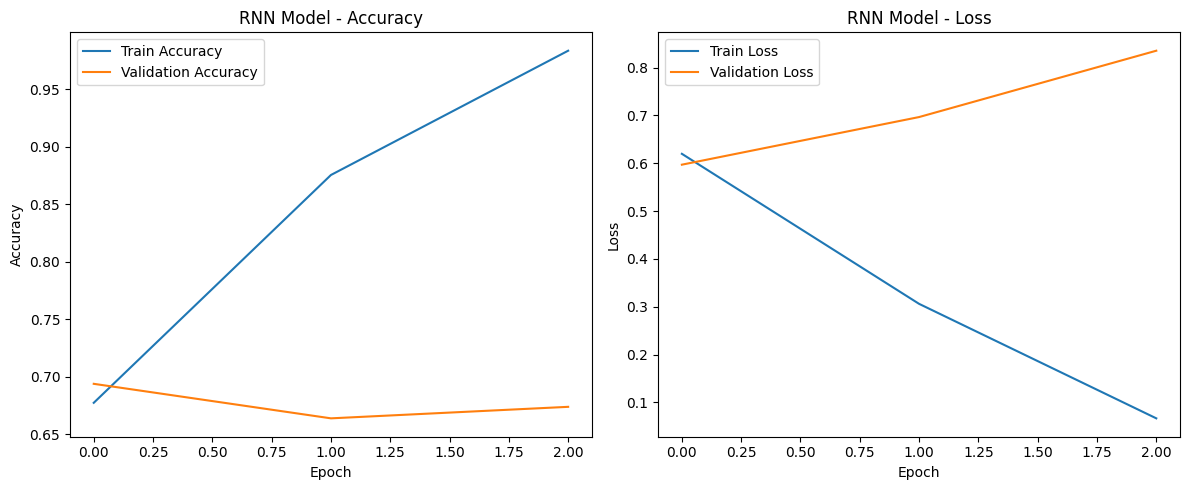

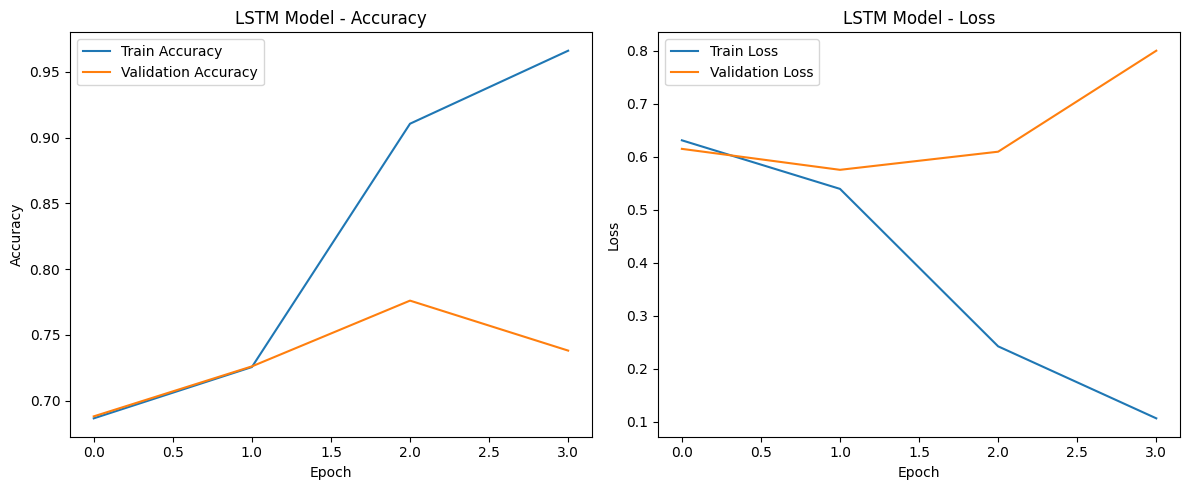

y_test shape: (370025,)
X_test_pad shape: (370025, 16)
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step
RNN predictions shape: (370025, 1)
LSTM predictions shape: (370025, 1)


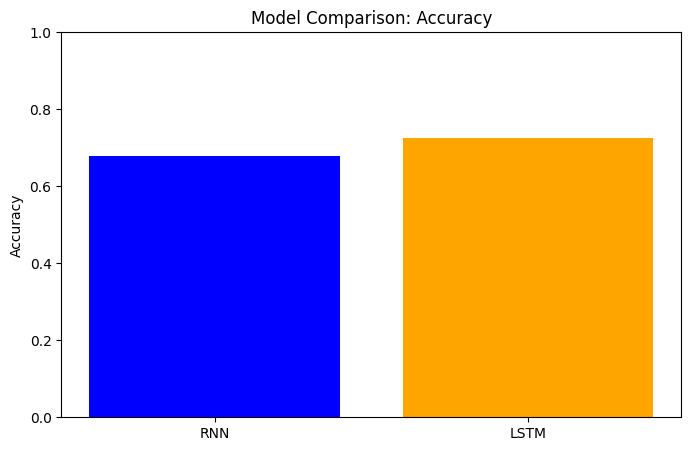

In [7]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(rnn_history, 'RNN Model')
plot_history(lstm_history, 'LSTM Model')

# Compare final performance
plt.figure(figsize=(8, 5))

# First verify shapes
print(f"y_test shape: {y_test.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}")

# Make sure we're using the same test set for both models
rnn_pred = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")
lstm_pred = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Verify prediction shapes match y_test
print(f"RNN predictions shape: {rnn_pred.shape}")
print(f"LSTM predictions shape: {lstm_pred.shape}")

# If shapes still don't match, we might need to adjust
if len(y_test) != len(rnn_pred):
    # Take the first n predictions where n matches y_test length
    min_length = min(len(y_test), len(rnn_pred))
    y_test = y_test[:min_length]
    rnn_pred = rnn_pred[:min_length]
    lstm_pred = lstm_pred[:min_length]

models = ['RNN', 'LSTM']
accuracies = [accuracy_score(y_test, rnn_pred), accuracy_score(y_test, lstm_pred)]
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Comparison: Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [8]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.0 MB/s eta 0:00:00


In [9]:
from IPython.display import display
import ipywidgets as widgets
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Sample dataset of tweets (positive and negative sentiment)
tweets = [
    ("I love America and its people!", 1),
    ("This administration is doing great work.", 1),
    ("Fake news is spreading lies about me.", 0),
    ("The economy is booming like never before!", 1),
    ("Corrupt politicians are ruining our country.", 0),
    ("We will make America great again!", 1),
    ("The media hates me because I tell the truth.", 0),
    ("Our military is stronger than ever.", 1),
    ("Crooked Hillary is a disgrace to politics.", 0),
    ("Together, we can achieve greatness.", 1)
]

# Separate tweets and labels
texts, labels = zip(*tweets)

# Clean text function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = text.strip()
    return text

# Preprocess the tweets
cleaned_texts = [clean_text(text) for text in texts]

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(cleaned_texts)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")

# Create widgets
text_input = widgets.Textarea(placeholder="Paste Trump tweet here...", layout={'width': '500px', 'height': '100px'})
analyze_btn = widgets.Button(description="Analyze Sentiment", button_style='success')
output = widgets.Output()

def on_analyze_click(b):
    with output:
        output.clear_output()
        text = text_input.value
        if not text.strip():
            print("⚠️ Please enter a tweet!")
            return

        cleaned_text = clean_text(text)
        text_vector = tfidf.transform([cleaned_text])
        prediction = model.predict(text_vector)[0]
        confidence = max(model.predict_proba(text_vector)[0])

        sentiment = "👍 POSITIVE" if prediction == 1 else "👎 NEGATIVE"
        print(f"RESULT: {sentiment}")
        print(f"Confidence: {confidence:.2%}")

analyze_btn.on_click(on_analyze_click)
display(widgets.VBox([widgets.Label("Trump Tweet Sentiment Analysis:"),
                     text_input,
                     analyze_btn,
                     output]))

Model Accuracy: 50.00%


In [10]:
rnn_model.save('Week9_rnn_model.h5')

lstm_model.save('Week9_lstm_model.h5')